c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


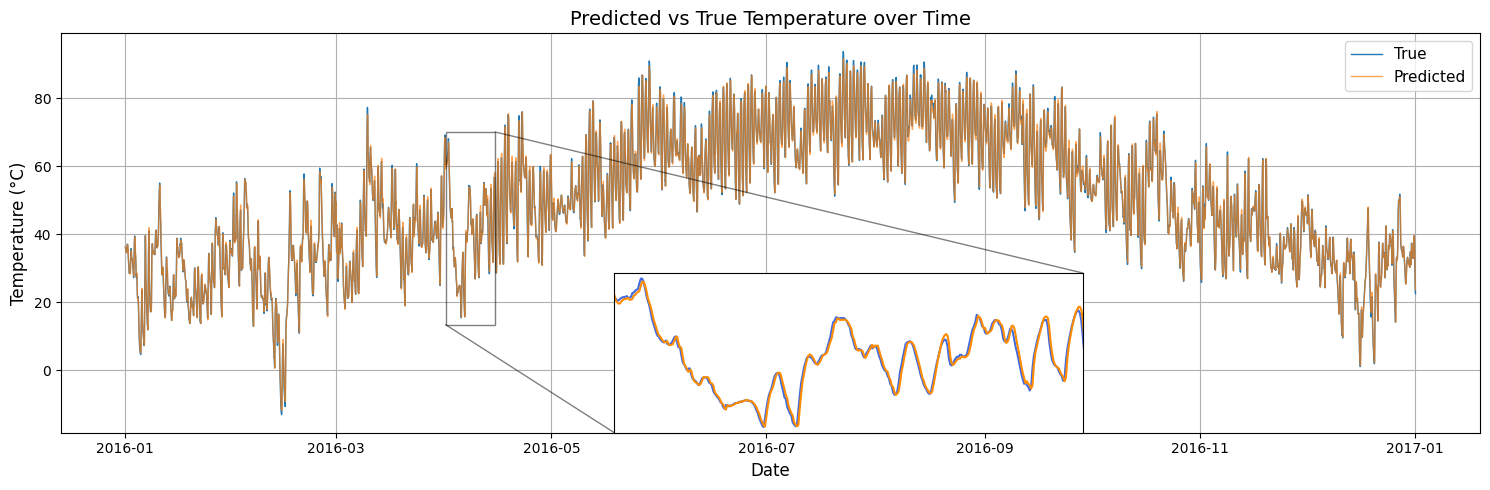

In [3]:
# === IMPORTS ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from keras.optimizers import Adam
from src.data.data_handler import DataHandler         # Custom data handler class
from src.models.lstm_model import LSTMModel           # Custom LSTM model class
from matplotlib.dates import DateFormatter
from matplotlib import rcParams

# === CONFIGURATION ===
# Define experiment name and paths for model, scaler, and data
exp_name = 'lstm_temp_1_24_lags_pressure_humidity'
base_dir = f'D:/Data science/energy-forecasting-ml/outputs/experiments_UMass/temp/{exp_name}'
checkpoint_path = os.path.join(base_dir, 'checkpoints', 'best_lstm_model.keras')
scaler_path     = os.path.join(base_dir, 'metrics', 'y_scaler.pkl')
csv_path        = 'D:/Data science/energy-forecasting-ml/data/processed/UMass Smart Dataset/weather_lag.csv'

# === LOAD DATA ===
# Initialize data handler for sequence and static features
dh = DataHandler(
    csv_path      = csv_path,
    date_col      = 'time',
    feature_cols  = ['temperature_lag_1', 'temperature_lag_24', 'pressure', 'humidity'],
    target_col    = 'temperature',
    no_scale_cols = [],
    holdout_years = 1,
    scaler_type   = 'standard'
)

# Load full dataset and split into train/val and test sets
df_all = dh.load_data()
df_trainval, df_test = dh.temporal_split(df_all)

# Save test set dates for plotting (before the column is dropped later)
test_dates = df_test[dh.date_col].reset_index(drop=True)

# Extract sequential and static input arrays and targets
X_seq_tr, X_stat_tr, y_tr, X_seq_val, X_stat_val, y_val, X_seq_te, X_stat_te, y_te = \
    dh.get_sequence_data(val_years=1)

# Prepare input dictionary for testing
X_test_dict = {
    'seq_input': X_seq_te,
    'static_input': X_stat_te
}

# === MODEL RECONSTRUCTION ===
# Set model architecture and training parameters (used for consistency)
params = {
    'input_shape_seq': X_seq_te.shape[1:],       # Shape of sequence input
    'input_shape_stat': X_stat_te.shape[1],      # Shape of static input
    'lstm_units': 64,
    'dense_units': 128,
    'optimizer': Adam(learning_rate=1e-4),
    'loss': 'mse',
    'metrics': ['mae'],
    'epochs': 200,
    'batch_size': 32,
    'early_stop_patience': 10,
    'checkpoint_path': checkpoint_path,
    'scale_y': True,
    'verbose': 1,
    'scale_mode': 'standard',
}

# Instantiate the model and load trained weights
model = LSTMModel(params)
model.model.load_weights(checkpoint_path)

# === PREDICTIONS ===
# Load the target scaler and inverse transform the predictions
y_scaler = joblib.load(scaler_path)
preds_scaled = model.predict(X_test_dict)
y_pred = y_scaler.inverse_transform(preds_scaled)
y_true = y_te

# === PLOT PREDICTIONS VS TRUE VALUES ===
# Set clean visual style
plt.style.use('default') 
rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12, 'legend.fontsize': 11})
fig, ax = plt.subplots(figsize=(15, 5))

# Plot true and predicted temperature curves
ax.plot(test_dates, y_true, label='True', linewidth=1)
ax.plot(test_dates, y_pred, label='Predicted', linewidth=1, alpha=0.7)

# Add title and axis labels
ax.set_title('Predicted vs True Temperature over Time', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.legend()
ax.grid(True)
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))  # Format x-axis as year-month

# === ADD ZOOMED-IN INSET ===
# Define zoom interval
zoom_start = pd.to_datetime('2016-04-01')
zoom_end   = pd.to_datetime('2016-04-15')

# Create zoomed inset axis within the main plot
axins = ax.inset_axes([0.39, 0, 0.33, 0.4])  # [x0, y0, width, height]
axins.plot(test_dates, y_true, color='royalblue')
axins.plot(test_dates, y_pred, color='darkorange')

# Set limits for zoomed region
axins.set_xlim(zoom_start, zoom_end)
axins.set_ylim(
    min(y_true[(test_dates >= zoom_start) & (test_dates <= zoom_end)]) - 2,
    max(y_true[(test_dates >= zoom_start) & (test_dates <= zoom_end)]) + 2
)

# Hide ticks in the inset
axins.set_xticks([])
axins.set_yticks([])

# Draw a rectangle and lines showing zoom region
ax.indicate_inset_zoom(axins, edgecolor="black")

# Final layout adjustments
plt.tight_layout()
plt.show()


In [ ]:
# === IMPORTS ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from keras.optimizers import Adam
from src.models.lstm_model import LSTMModel      # Custom LSTM class
from src.data.data_handler import DataHandler    # Custom data handler for sequences

# === PATHS ===
# Define experiment name and path to model, scalers, and test CSV
exp_name       = 'lstm_smartumass_multiappart_lag_temp_cyclical'
base_dir       = os.path.join('D:/Data science/energy-forecasting-ml/outputs', 'experiments_UMass', exp_name)
model_path     = os.path.join(base_dir, 'checkpoints', 'best_lstm_model.keras')
scaler_x_path  = os.path.join(base_dir, 'x_scaler.pkl')
scaler_y_path  = os.path.join(base_dir, 'y_scaler.pkl')
csv_path_test  = 'D:/Data science/energy-forecasting-ml/data/processed/UMass Smart Dataset/test_ready_Apt75_2015.csv'

# === COLUMNS USED ===
# Specify time column, target, and input features
date_col      = 'time'
target_col    = 'power [kW]'
feature_cols  = ['power [kW]_lag_1', 'power [kW]_lag_24', 'power [kW]_lag_168', 'temperature',
                 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']
no_scale_cols = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']

# === LOAD INPUT SCALER ===
x_scaler = joblib.load(scaler_x_path)

# === LOAD TEST DATA ===
df_test = pd.read_csv(csv_path_test, parse_dates=[date_col])
X_test_ap = df_test[feature_cols].copy()
y_test_ap = df_test[target_col].values  # Ground truth values

# === APPLY SCALING ON X TEST DATA ===
cols_to_scale = [c for c in feature_cols if c not in no_scale_cols]
X_test_ap[cols_to_scale] = x_scaler.transform(X_test_ap[cols_to_scale])

# === RECREATE FULL TEST SET WITH SCALED X AND ORIGINAL Y ===
df_test_scaled = X_test_ap.copy()
df_test_scaled[target_col] = y_test_ap  # Reattach unscaled target for sequence generation

# === CREATE SEQUENCES FROM THE SCALED TEST DATA ===
dh_test = DataHandler(
    csv_path=csv_path_test,
    date_col=date_col,
    feature_cols=feature_cols,
    target_col=target_col,
    no_scale_cols=no_scale_cols,
    holdout_ratio=0,
    holdout_years=None,
    scaler_type='standard'
)
X_seq_te, X_stat_te, y_te = dh_test.create_sequences(df_test_scaled)

# Prepare input dictionary (for models with multiple input branches)
X_test_dict = {'seq_input': X_seq_te, 'static_input': X_stat_te}

# === REINSTANTIATE THE LSTM MODEL USING TRAINING PARAMETERS ===
params = {
    'input_shape_seq': X_seq_te.shape[1:],  # shape = (timesteps, features)
    'input_shape_stat': X_stat_te.shape[1] if X_stat_te is not None else 0,
    'lstm_units': 64,
    'dense_units': 256,
    'loss': 'mse',
    'metrics': ['mae'],
    'optimizer': Adam(learning_rate=5e-5),
    'scale_mode': 'standard'
}
lstm_loaded = LSTMModel(params)

# Load the trained model weights
lstm_loaded.model.load_weights(model_path)

# === LOAD TARGET SCALER ===
y_scaler = joblib.load(scaler_y_path)
lstm_loaded.y_scaler = y_scaler  # Attach it to the model for consistent inverse transform

# === MAKE PREDICTIONS ===
y_pred = lstm_loaded.predict(X_test_dict)

# Inverse transform the predicted values back to original scale
y_predi = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()

# === PLOT PREDICTIONS VS TRUE VALUES ===
plt.figure(figsize=(15, 5))
plt.plot(y_te, label='True', linewidth=1.5)
plt.plot(y_predi, label='Predicted', linewidth=1.2)
plt.title('True vs Predicted Power Consumption (Test Set)')
plt.xlabel('Time Step')  # Each point corresponds to a time step (e.g. hourly)
plt.ylabel('Power [kW]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 1 objects could not be loaded. Example error message for object <Dense name=dense_11, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(129, 256), Received: value.shape=(135, 256). Target variable: <KerasVariable shape=(129, 256), dtype=float32, path=dense_11/kernel>

List of objects that could not be loaded:
[<Dense name=dense_11, built=True>]

1. Preparing test data...
   -> Test data ready.

2. Recreating model, loading weights, and loading scaler...


c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


   -> Model recreated and assets loaded successfully.

3. Generating predictions on the test set...
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
   -> Inverse transforming predictions to original scale...
   -> Predictions are ready for visualization.

4. Creating and saving prediction visualization...
   -> Prediction visualization saved to: outputs\evaluations\evaluation_lstm_quantile_experiment_bs_32_bidirectional_64_q01-50-99_minmax\lstm_evaluation_plot.png


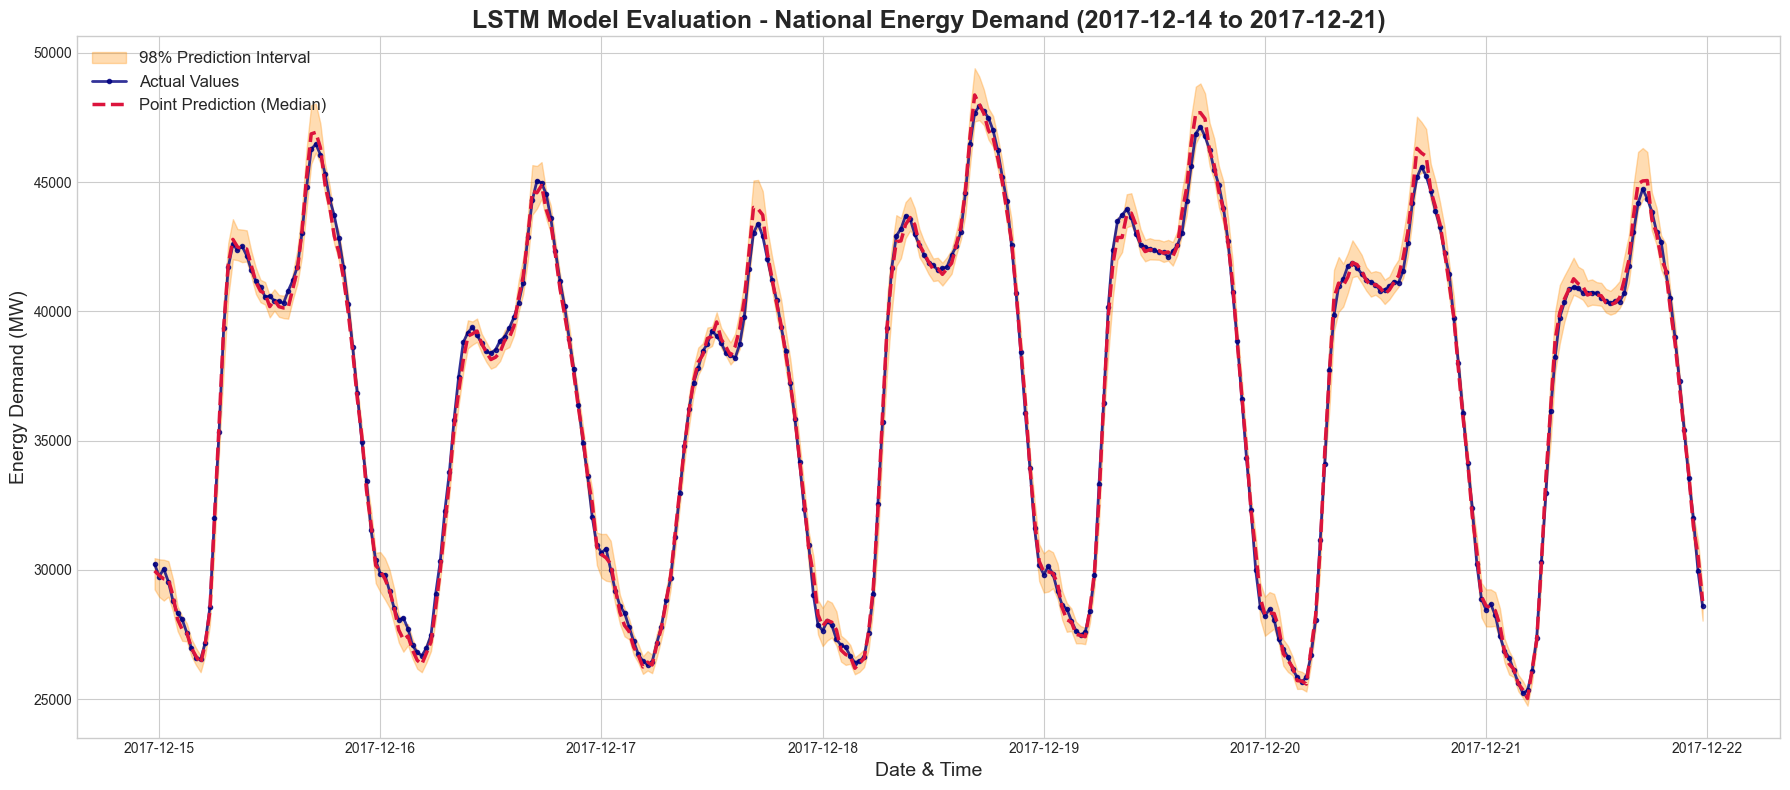

In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# --- Step 1: Import the necessary model and data classes ---
from src.models.lstm_quantile_model import LSTMQuantileModel, quantile_loss
from src.data.data_handler import DataHandler
from keras.optimizers import Adam


# --- Step 2: Define Paths and Parameters ---
# These must be identical to your training setup
exp_name = 'lstm_quantile_experiment_bs_32_bidirectional_64_q01-50-99_minmax'
base_dir = os.path.join('outputs', 'experiments', exp_name)
model_path = 'D:/Data science/energy-forecasting-ml/outputs/experiments/lstm_quantile_experiment_bs_32_bidirectional_64_q01-50-99_minmax_save/checkpoints/best_lstm_quantile_model.keras'
scaler_path = 'D:/Data science/energy-forecasting-ml/outputs/experiments/lstm_quantile_experiment_bs_32_bidirectional_64_q01-50-99_minmax_save/y_scaler.pkl'
output_dir = os.path.join('outputs', 'evaluations', f'evaluation_{exp_name}')
os.makedirs(output_dir, exist_ok=True)

# Data and model parameters
csv_path = 'D:\\Data science\\energy-forecasting-ml\\data\\processed\\NESO_UK\\preprocessed_new_features_cleaned_DemandData_2011-2018.csv'
date_col = 'datetime'
target_col = 'I014_ND'
quantiles = [0.01, 0.5, 0.99]
feature_cols = [
    'NON_BM_STOR','I014_PUMP_STORAGE_PUMPING','is_interpolated','is_weekend',
    'I014_ND_lag_1','I014_ND_lag_2','I014_ND_lag_48','I014_ND_lag_96','I014_ND_lag_336',
    'I014_ND_mean_48','I014_ND_mean_336','net_import','wind_capacity_factor',
    'solar_capacity_factor','hour_sin','hour_cos','weekday_sin','weekday_cos','month_sin','month_cos'
]
no_scale_cols = [
    'is_interpolated','is_weekend',
    'hour_sin','hour_cos','weekday_sin','weekday_cos','month_sin','month_cos'
]


# --- Step 3: Prepare the Test Data ---
# We do this first to get the data shapes required to build the model
print("1. Preparing test data...")
data_handler = DataHandler(
    csv_path=csv_path, date_col=date_col, feature_cols=feature_cols,
    target_col=target_col, no_scale_cols=no_scale_cols,
    holdout_years=1, scaler_type='minmax'
)
_, _, _, _, _, _, X_seq_te, X_stat_te, y_te = data_handler.get_sequence_data(val_years=1)
X_test_dict = {'seq_input': X_seq_te, 'static_input': X_stat_te}
print("   -> Test data ready.")


# --- Step 4: Recreate Model, Load Weights, and Load Scaler ---
print("\n2. Recreating model, loading weights, and loading scaler...")
try:
    # Define model hyperparameters using the shape of our test data
    params = {
        'input_shape_seq': X_seq_te.shape[1:],
        'input_shape_stat': X_stat_te.shape[1],
        'lstm_units': 64,
        'dense_units': 256,
        'quantiles': quantiles,
    }

    # A) Create a fresh instance of the model architecture
    model_instance = LSTMQuantileModel(params)
    loaded_model = model_instance.model

    # B) Load the saved weights into the newly created model
    loaded_model.load_weights(model_path)

    # C) Load the scaler
    y_scaler = joblib.load(scaler_path)

    print("   -> Model recreated and assets loaded successfully.")

except Exception as e:
    print(f"ERROR: Failed to recreate the model or load assets.")
    print(f"Please check that the model class is available and parameters match training.")
    print(e)
    exit()


# --- Step 5: Generate and Process Predictions ---
print("\n3. Generating predictions on the test set...")
scaled_preds = loaded_model.predict(X_test_dict)
scaled_lower, scaled_median, scaled_upper = scaled_preds[0], scaled_preds[1], scaled_preds[2]

print("   -> Inverse transforming predictions to original scale...")
lower_bound = y_scaler.inverse_transform(scaled_lower).ravel()
median_pred = y_scaler.inverse_transform(scaled_median).ravel()
upper_bound = y_scaler.inverse_transform(scaled_upper).ravel()
print("   -> Predictions are ready for visualization.")


# --- Step 6: Create and Save Prediction Visualization ---
print("\n4. Creating and saving prediction visualization...")
df_full_dates = data_handler.load_data()[[date_col]]
df_test_dates = df_full_dates.iloc[-len(y_te):]
results_df = pd.DataFrame({
    'datetime': df_test_dates[date_col].values,
    'y_true': y_te, 'y_pred': median_pred,
    'lower_bound': lower_bound, 'upper_bound': upper_bound
}).set_index('datetime')

start_date = results_df.index.min()
end_date = start_date + pd.Timedelta(days=7)
results_subset = results_df.loc[start_date:end_date]

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))
ax.fill_between(
    results_subset.index, results_subset['lower_bound'], results_subset['upper_bound'],
    color='darkorange', alpha=0.3, label=f'{(quantiles[2] - quantiles[0]) * 100:.0f}% Prediction Interval'
)
ax.plot(
    results_subset.index, results_subset['y_true'], color='navy', linewidth=2,
    marker='o', markersize=3, alpha=0.8, label='Actual Values'
)
ax.plot(
    results_subset.index, results_subset['y_pred'], color='crimson',
    linestyle='--', linewidth=2.5, label='Point Prediction (Median)'
)
ax.set_title(f'LSTM Model Evaluation - National Energy Demand ({start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")})', fontsize=18, fontweight='bold')
ax.set_xlabel('Date & Time', fontsize=14)
ax.set_ylabel('Energy Demand (MW)', fontsize=14)
ax.legend(fontsize=12, loc='upper left')
plt.tight_layout()

output_path = os.path.join(output_dir, 'lstm_evaluation_plot.png')
plt.savefig(output_path, dpi=300)
print(f"   -> Prediction visualization saved to: {output_path}")

plt.show()